# Correlation between [CII] and the Spitzer 8 micron emission

Performed on the full FEEDBACK maps (specified in "User input"), no further down selection of sub regions is done in this Notebook.

In [1]:
import numpy as np
import astropy.io.fits as pyfits
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time

from numpy.random import randint
from scipy.stats import pearsonr

import support_functions as sup

In [2]:
#### User input ####

## information to fetch the necessary data
dir_path = "../data_CIIcorr/data_FEEDBACK/" ## path to the data directory
name_CII = "_CII_final_res20_grid8_0p5_clean_integrated" ## identifier of the [CII] data file
name_8m = "_Spitzer_IRAC_8_20_8" ## identifier of the 8 micron data file
plot_path = "../plots_CIIcorr/CII_correlations/"

list_regions = [ ## list of the regions to be studied
    "CYGNUSX",
    "M16",
    "M17",
    "NGC7538",
    "RCW36",
    "RCW49",
    "RCW79",
    "RCW120",
    "W40",
    "ORIONA"
]

## minimal intensity for the [CII] data
min_cut_CII = 20. 

## minimum number of data points for histogram plots
min_hist = 10

## Maximum number of data points that will be randomly sampled to produce the kdeplot
num_points_kdeplot = 1e4

## plotting information
xlims = [-2.5,-0.3]
ylims = [-3.9, -2.2]

In [3]:
## Load the dataframes for each region into a single list
data_list = [] ## to store the [CII] and 8 micron DataFrame for the different regions

for region in list_regions:
    print("Performing the plotting for {reg}".format(reg = region))
    
    ## read the data into a Pandas DataFrame
    df = sup.read_data_to_DF(
        "{path}{region}/{region}{CII}.fits".format(path = dir_path, region = region, CII = name_CII),
        "{path}{region}/{region}{name}.fits".format(path = dir_path, region = region, name = name_8m),
        min_cut_CII,
        region
    )
    
    ## store the data
    data_list.append(df)

Performing the plotting for CYGNUSX
Performing the plotting for M16
Performing the plotting for M17
Performing the plotting for NGC7538
Performing the plotting for RCW36
Performing the plotting for RCW49
Performing the plotting for RCW79
Performing the plotting for RCW120
Performing the plotting for W40
Performing the plotting for ORIONA


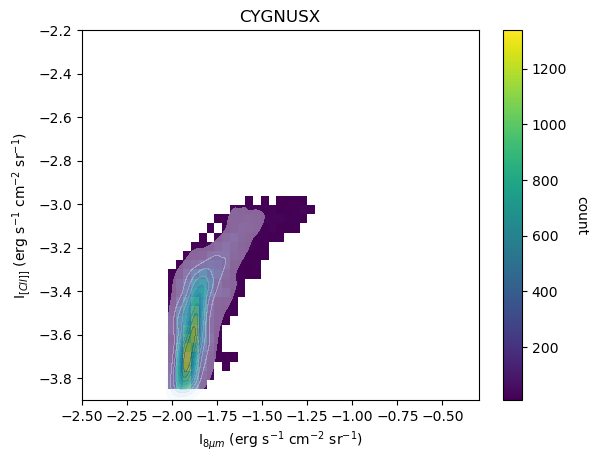

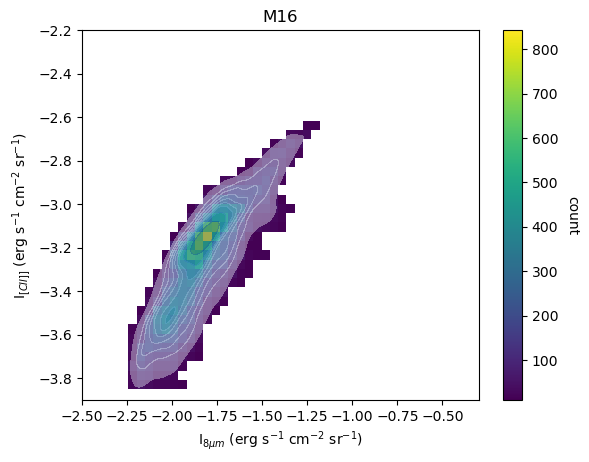

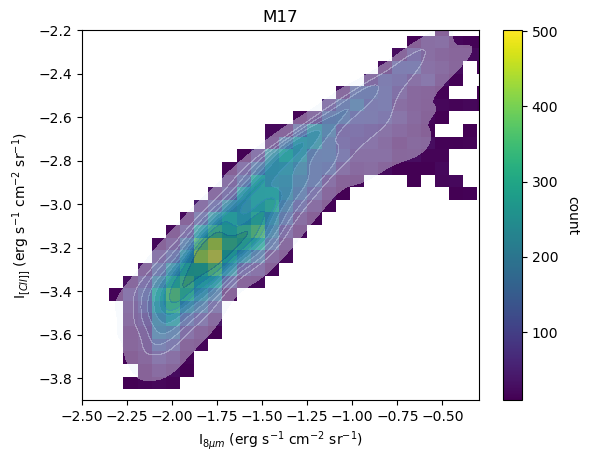

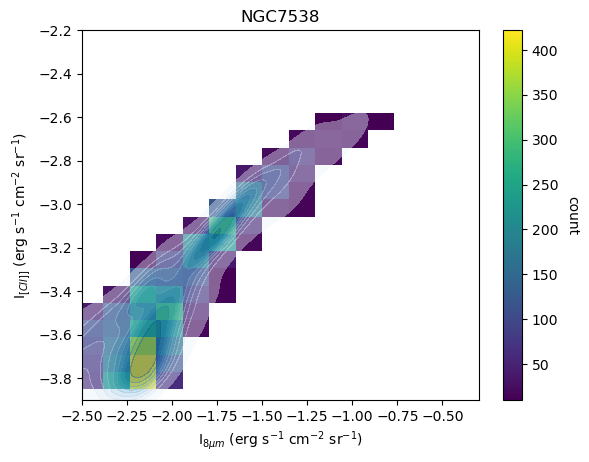

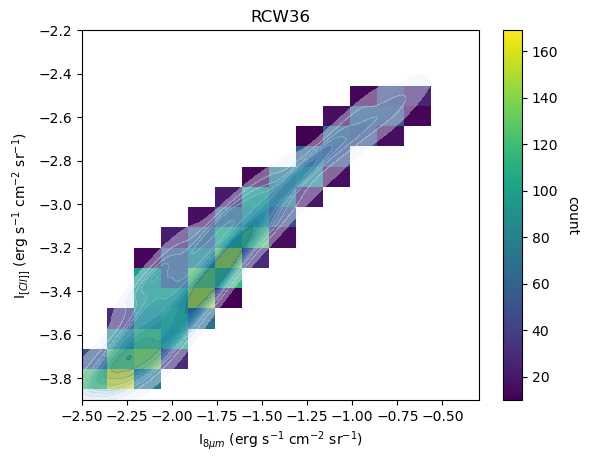

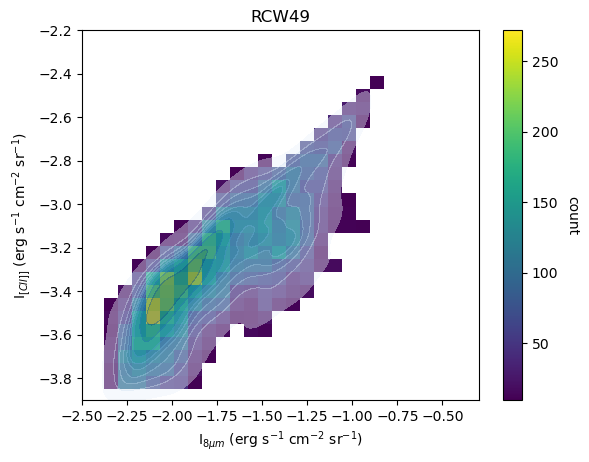

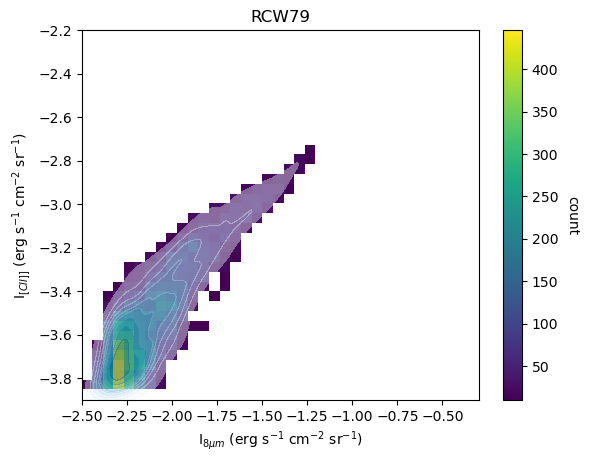

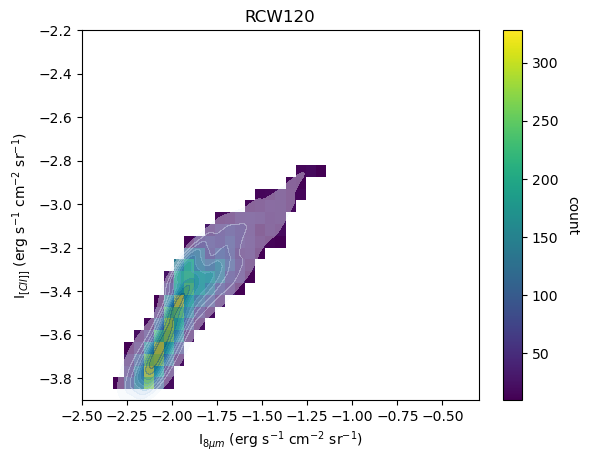

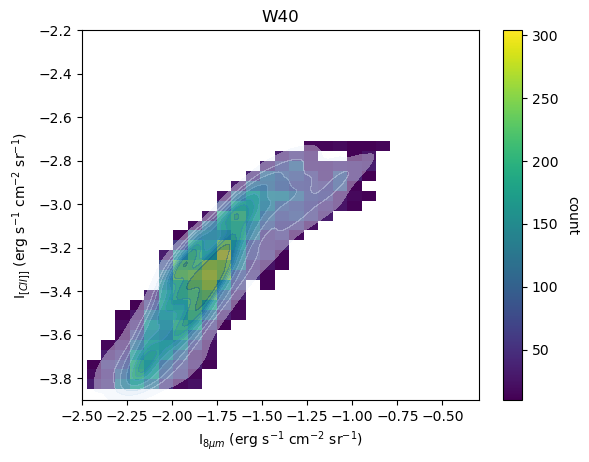

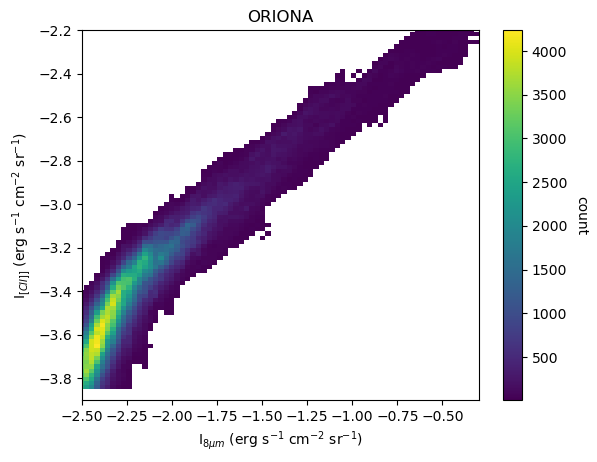

In [4]:
## plotting 2D histogram + seaborn for each region
for df, region in zip(data_list, list_regions):
    ## Add a title
    plt.title(region)
    
    ## plotting correlation 8 micron with the 2D histogram
    h = plt.hist2d(df["8 micron"], df["CII"], bins = int((len(df["CII"]))**0.33), cmin = min_hist)
    
    ## add a colorbar
    cbar = plt.colorbar()
    cbar.set_label("count", rotation = 270, labelpad = 15)

    ## plot kdeplot
    if(region != "ORIONA"):
        g = sns.kdeplot(df, x = "8 micron", y = "CII", fill=True, cmap='Blues', alpha=0.4)

    plt.ylabel('I$_{[CII]]}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    plt.xlabel('I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    
    plt.xlim(xlims)
    plt.ylim(ylims)
    
    #plt.savefig("{path}{region}_CIIvs8micron.pdf".format(path = plot_path, region = region))
    plt.show()

In [5]:
from scipy.optimize import curve_fit

In [6]:
#### functions ####

## Function to calculate the mean intensities for all histogram bins (returns: np.array)
def calc_bin_CIImeans(df, xbin_points):
    mean_vals = []
    
    ## loop over the bins, extract all points and calculate the average
    for j in range(0, len(xbin_points)-1):
        temp_df = df.loc[(df["8 micron"] > xbin_points[j]) & (df["8 micron"] < xbin_points[j+1])]
        if(len(temp_df.index) > 3*min_hist): ## *3 assures sufficient data points are considered
            mean_vals.append(temp_df["CII"].mean())
        else:
            mean_vals.append(np.nan)
    
    ## calculate the x-values (8 micron) for each mean (CII) value
    delta_xbin = xbin_points[1] - xbin_points[0]
    means_x = xbin_points[:-1] + 0.5*delta_xbin
    
    return np.array(mean_vals), means_x

## Function to calculate the gradients for the mean values (returns np.array, np.array)
def calc_grads(x_points, means_arr):
    ## define storage lists
    grads_arr = []
    grads_x = []
    
    ## loop over the values to calculate the gradients and their corresponding x-value
    for j in range(0, len(means_arr)-1):
        if(~np.isnan(means_arr[j+1]) and ~np.isnan(means_arr[j])):
            grads_arr.append((means_arr[j+1] - means_arr[j])/(x_points[j+1] - x_points[j]))
            grads_x.append(0.5*(x_points[j+1] + x_points[j]))
    
    return np.array(grads_arr), np.array(grads_x)
        
        


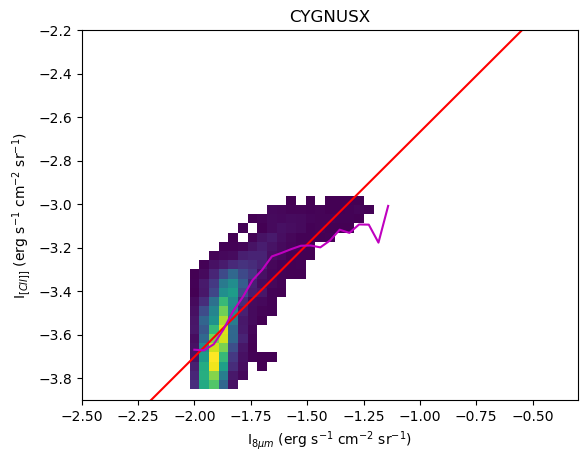

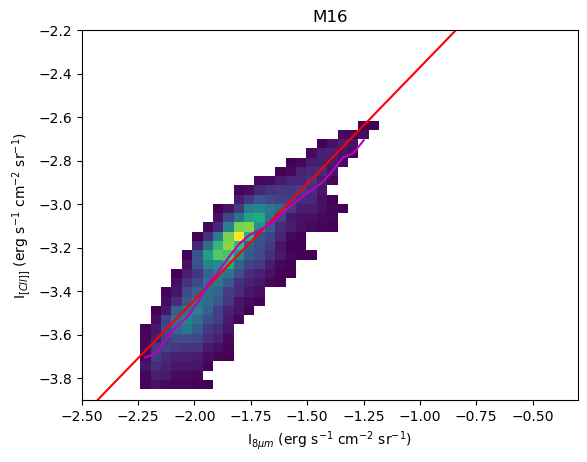

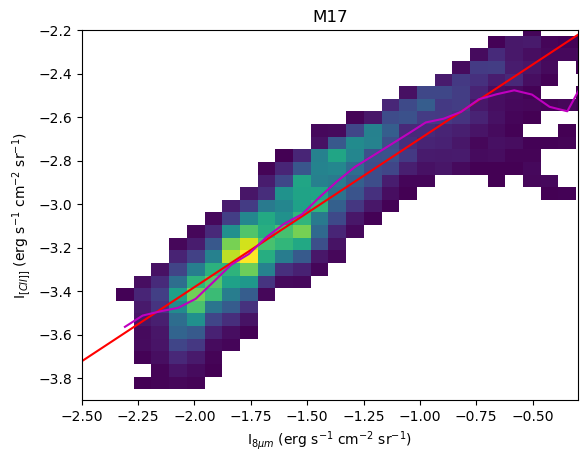

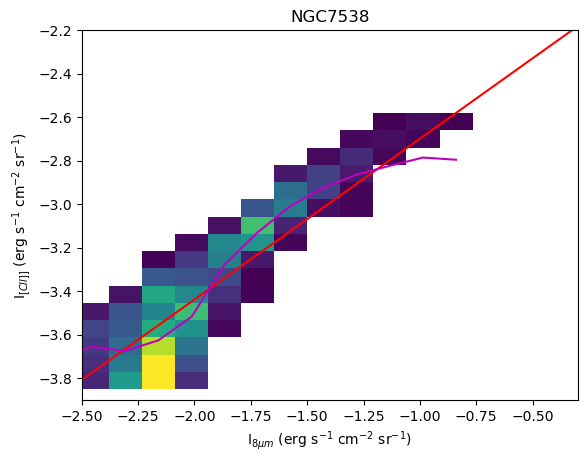

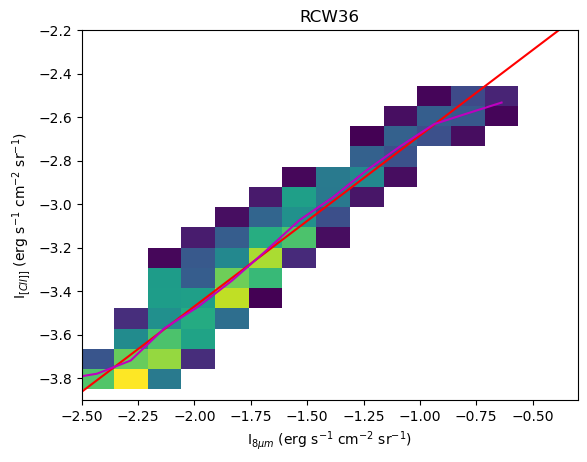

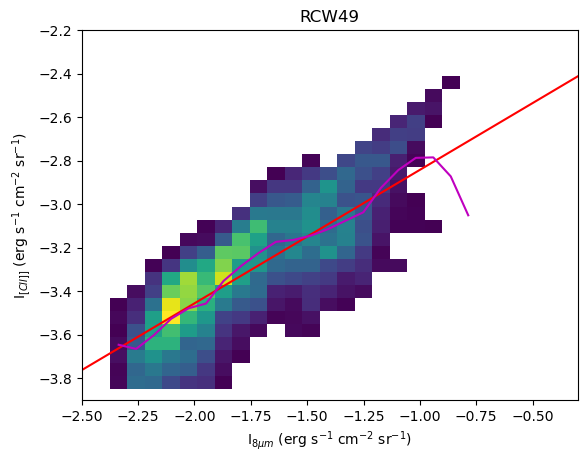

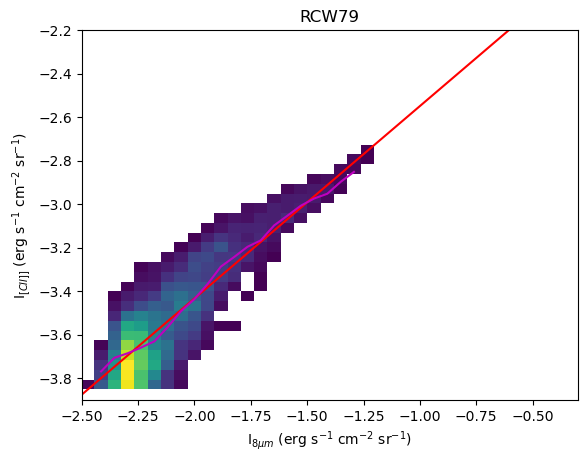

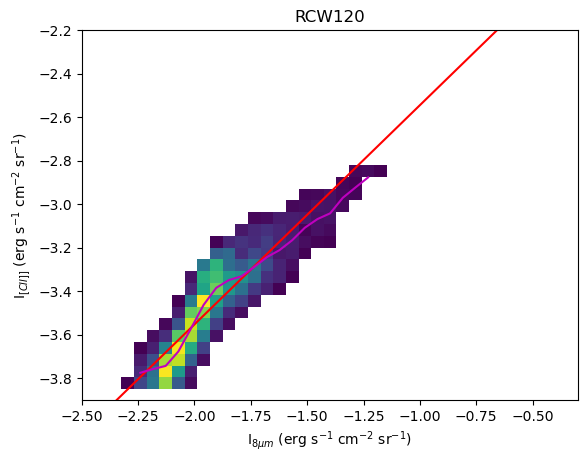

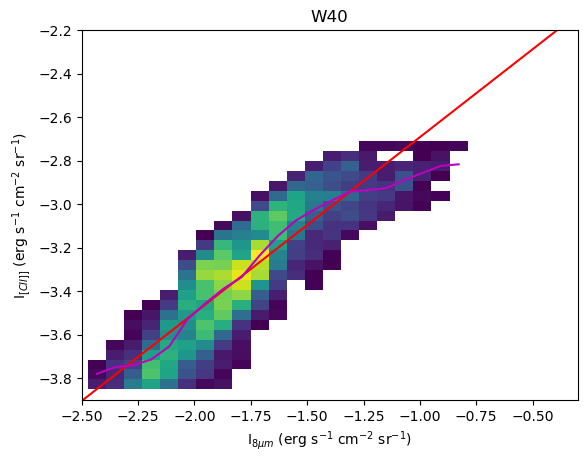

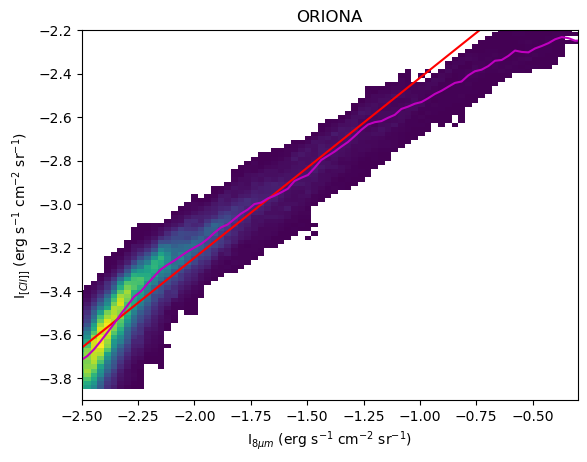

In [7]:
## fit the data with a powerlaw, calculate the gradients and plot the results
popt_list = []
pcov_list = []

grads_list = []
grads_x_list = []

## loop over the regions in the list
for df, region in zip(data_list, list_regions):
    ## perform the fitting
    popt, pcov = curve_fit(sup.lin_func, df["8 micron"], df["CII"])
    popt_list.append(popt)
    pcov_list.append(pcov)
    
    ## create information to plot the fitted curve
    x_points_fit = np.linspace(start = xlims[0], stop = xlims[1], num = 100)
    y_points_fit = sup.lin_func(x_points_fit, popt[0], popt[1])
    
    ## plot the fitted curve on top of the 2D histograms ##
    # Add a title
    plt.title(region)
    
    ## plotting correlation 8 micron with the 2D histogram
    h = plt.hist2d(df["8 micron"], df["CII"], bins = int((len(df["CII"]))**0.33), cmin = min_hist)
    xbin_points = h[1]
    #delta_xbin = xbin_points[1] - xbin_points[0]
    
    ## calculate the mean value for each x location in the histogram
    means_arr, means_x = calc_bin_CIImeans(df, xbin_points)
    #means_x = xbin_points[:-1] + 0.5*delta_xbin
    
    ## calculate the local gradients in the 2D histogram
    grads, grads_x = calc_grads(means_x, means_arr)
    grads_list.append(grads)
    grads_x_list.append(grads_x)
    
    ## plot the fitted relation
    plt.plot(x_points_fit, y_points_fit, "r-")
    
    ## plot the means for each x (i.e. 8 micron) value of the 2D histogram
    plt.plot(means_x, means_arr, "m-")
    
    ## additional plot specifications
    plt.ylabel('I$_{[CII]]}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    plt.xlabel('I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
    
    plt.xlim(xlims)
    plt.ylim(ylims)
    
    #plt.savefig("{path}{region}_CIIvs8micron+fit.pdf".format(path = plot_path, region = region))
    plt.show()

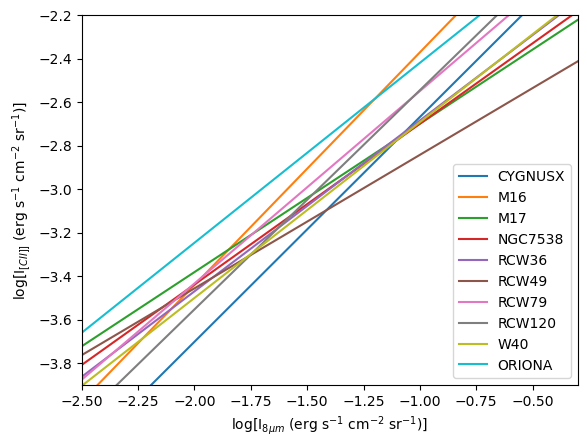

In [8]:
## plot to compare the different fitted relations
for popt, region in zip(popt_list, list_regions):
    ## create information to plot the fitted curve
    x_points_fit = np.linspace(start = xlims[0], stop = xlims[1], num = 100)
    y_points_fit = sup.lin_func(x_points_fit, popt[0], popt[1])
    
    ## plot the fitted relation
    plt.plot(x_points_fit, y_points_fit, label = region)
    
    plt.xlim(xlims)
    plt.ylim(ylims)
    
    ## additional plot specifications
    plt.ylabel('log[I$_{[CII]]}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]')
    plt.xlabel('log[I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]')
    
    plt.legend()

#plt.savefig("{path}fits_CIIvs8micron.pdf".format(path = plot_path))
plt.show()

In [9]:
## Evaluate the [CII] vs 8 micron powerlaw exponent as a function of 8 micron intensity

## create np.arrays of all gradients
all_grads = np.concatenate(grads_list, axis = None)
all_grads_x = np.concatenate(grads_x_list, axis = None)

## fit the powerlaw exponents as a function of the 8 micron intensity
popt_grads, pcov_grads = curve_fit(sup.lin_func, all_grads_x, all_grads)
print("The relation between the power law exponent and log of the 8 micron intensity is given by {popt_grads} $\pm$ {pcov_grads}".format(popt_grads = popt_grads, pcov_grads = np.sqrt(np.diag(pcov_grads))))

## generate an array to plot the fit
fit_grads = sup.lin_func(x_points_fit, popt_grads[0], popt_grads[1])


## calculate and print the pearson correlation value
print(pearsonr(all_grads_x, all_grads))


The relation between the power law exponent and log of the 8 micron intensity is given by [-0.22456254  0.30264731] $\pm$ [0.05892459 0.09743998]
PearsonRResult(statistic=-0.23001212228367113, pvalue=0.0001728232866324037)


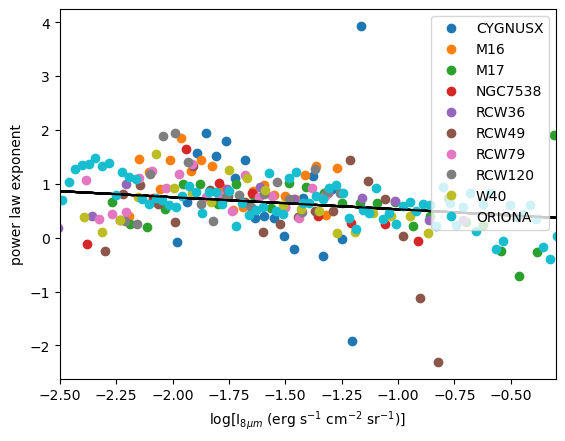

In [10]:
## plot to study the gradients as a function of 8 micron intensity
for grads, grads_x, region in zip(grads_list, grads_x_list, list_regions):
    ## plot the gradient values
    plt.plot(grads_x, grads, "o", label = region)
    
    ## plot the fit
    plt.plot(x_points_fit, fit_grads, "k-")
    
    plt.xlim(xlims)
    #plt.ylim(ylims)
    
    ## additional plot specifications
    plt.ylabel('power law exponent')
    plt.xlabel('log[I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]')
    
    plt.legend()

#plt.savefig("{path}exponentPLvs8micron+fit.pdf".format(path = plot_path))
plt.show()

The standard deviations on the powerlaw fit are [0.00615814 0.01146213]
The standard deviations on the powerlaw fit are [0.00371655 0.00684228]
The standard deviations on the powerlaw fit are [0.00202297 0.00321549]
The standard deviations on the powerlaw fit are [0.00541895 0.01094243]
The standard deviations on the powerlaw fit are [0.00419193 0.00771869]
The standard deviations on the powerlaw fit are [0.00385028 0.00679835]
The standard deviations on the powerlaw fit are [0.0042791  0.00908776]
The standard deviations on the powerlaw fit are [0.00538244 0.01038398]
The standard deviations on the powerlaw fit are [0.00334257 0.0060344 ]
The standard deviations on the powerlaw fit are [0.00034275 0.00077073]


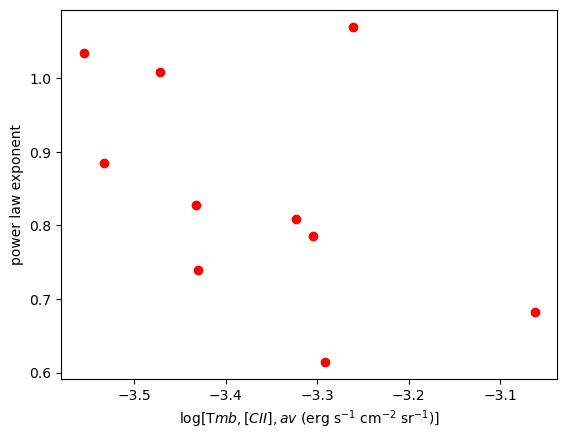

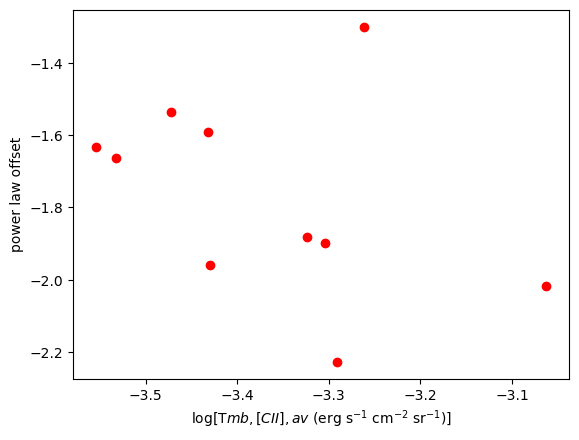

/var/folders/pb/xs3f5mtd5bq7lmrql1dj8p040000gn/T/ipykernel_55279/2052719392.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_regions, rotation = 25, ha="right")


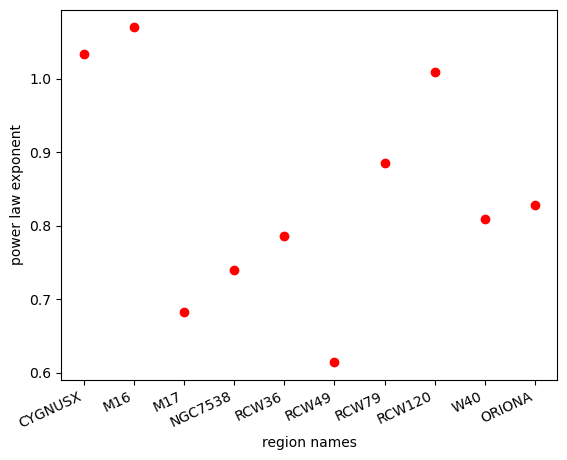

In [11]:
## investigate the link between the offset and powerlaw index as a function of average [CII] intensity
av_list = []
exp_list = []
exp_err_list = []
offset_list = []
offset_err_list = []
for popt, pcov, df in zip(popt_list, pcov_list, data_list):
    av_list.append(np.nanmean(df["CII"]))
    exp_list.append(popt[0])
    offset_list.append(popt[1])
    
    ## include the errors to the list
    perr = np.sqrt(np.diag(pcov))
    print("The standard deviations on the powerlaw fit are {perr}".format(perr = perr))
    exp_err_list = perr[0]
    offset_err_list = perr[1]

## plot the results
plt.errorbar(av_list, exp_list, yerr = exp_err_list, fmt = "o", color = "r")
plt.xlabel("log[T${mb, [CII], av}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]")
plt.ylabel("power law exponent")
#plt.savefig("{path}exponent-avTmb_CIIvs8micron.pdf".format(path = plot_path))
plt.show()

## plot the results
plt.errorbar(av_list, offset_list, yerr = offset_err_list, fmt = "o", color = "r")
plt.xlabel("log[T${mb, [CII], av}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]")
plt.ylabel("power law offset")
plt.show()

## plot the power law results for each region name
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.errorbar(list_regions, exp_list, yerr = exp_err_list, fmt = "o", color = "r")
ax.set_xticklabels(list_regions, rotation = 25, ha="right")
plt.ylabel("power law exponent")
plt.xlabel("region names")
plt.savefig("{path}exponentPL_regions.pdf".format(path = plot_path))
plt.show()
    

#### First conclusions
Regions with a lower intensity have a steeper power law: this indicates that the [CII]/ 8 micron relation flattens. What is the origin of this?
- Need to inspect presence of self-absorption

#### Inspecting the variance/scatter of the relation for each region

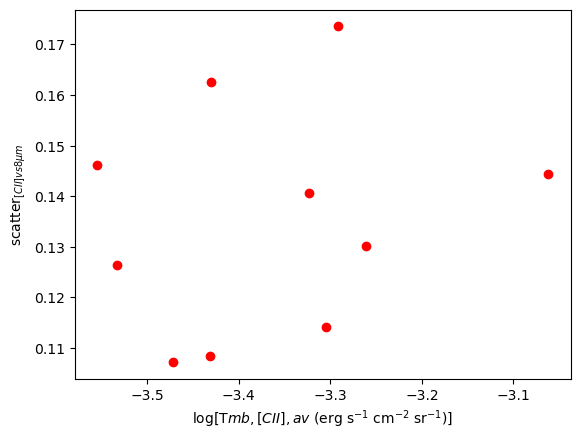

/var/folders/pb/xs3f5mtd5bq7lmrql1dj8p040000gn/T/ipykernel_55279/3593698668.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_regions, rotation = 25, ha="right")


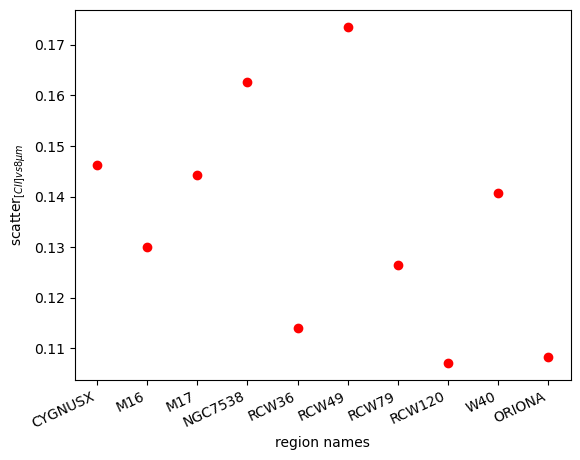

In [12]:
## calculating the standard deviation for each region
std_list = []
for df, popt in zip(data_list, popt_list):
    ## predict the [CII] intensity values for each 8 micron value based on the best fit
    pred_vals = sup.lin_func(df["8 micron"], popt[0], popt[1])
    
    ## calculate the difference between the predicted and observed [CII] intensity
    diff_vals = df["CII"] - pred_vals
    
    ## calculate the typical standard deviation
    std_list.append(np.nanstd(diff_vals))
    
## plot the results as a function of the intensity
plt.plot(av_list, std_list, "ro")
plt.ylabel(r"scatter$_{[CII] vs 8 \mu m}$")
plt.xlabel("log[T${mb, [CII], av}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)]")
#plt.savefig("{path}dispersionVsAvTmb_CIIvs8micron.pdf".format(path = plot_path))
plt.show()

## plot the results for each region name
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(list_regions, std_list, "ro")
ax.set_xticklabels(list_regions, rotation = 25, ha="right")
plt.ylabel(r"scatter$_{[CII] vs 8 \mu m}$")
plt.xlabel("region names")
#plt.savefig("{path}dispersion_CIIvs8micron.pdf".format(path = plot_path))
plt.show()